# [Surprise](https://surprise.readthedocs.io/en/stable/index.html) 라이브러리 활용

- Collaborative Filtering 관련 머신러닝 라이브러리 Surprise를 사용해봅시다
- 본 패키지는 KNN Collaborative Filtering 외에도 Matrix Factorization 등의 알고리즘도 제공하지만, 본 실습에서는 KNN 알고리즘만 사용합니다

## 학습 데이터 준비

In [1]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans
from surprise.model_selection.validation import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 학습 데이터가 들어있는 디렉토리 경로
path = '../data/ml-latest-small/'

In [3]:
ratings_df = pd.read_csv(path + 'ratings.csv', encoding='utf-8')

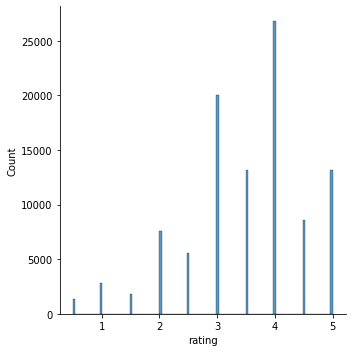

In [4]:
sns.displot(ratings_df['rating'])

In [5]:
# surprise에서 제공하는 dataset과 reader입니다
# https://surprise.readthedocs.io/en/stable/reader.html
# https://surprise.readthedocs.io/en/stable/dataset.html

from surprise import Reader, Dataset

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [6]:
type(data)

surprise.dataset.DatasetAutoFolds

## KNN Model

- [모델 API 문서](https://surprise.readthedocs.io/en/stable/knn_inspired.html)
- [유사도 API 문서](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration)

In [7]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# train / test 데이터 나누기, surprise에서 제공하는 함수

train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

# 기본 KNN 모델을 사용합니다
# user-based

sim_options = {
    'name': 'cosine',
    'user_based': True
}

knnbasic = KNNBasic(k = 40, min_k = 1, sim_options = sim_options)

# 학습 데이터를 가지고 모델을 학습하고, 예측을 수행합니다
knnbasic.fit(train_data)
predictions = knnbasic.test(test_data)

# 모델 성능을 rmse로 계산합니다
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9699


0.969943918550271

In [8]:
len(predictions)

20168

In [9]:
# cross validation 함수를 지원합니다
user_based_cv_result = cross_validate(knnbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9774  0.9747  0.9752  0.9782  0.9600  0.9731  0.0067  
MAE (testset)     0.7463  0.7499  0.7518  0.7546  0.7422  0.7490  0.0043  
Fit time          0.33    0.32    0.42    0.37    0.31    0.35    0.04    
Test time         1.32    1.50    1.49    1.55    1.83    1.54    0.17    


In [10]:
# item-based 추천

sim_options = {
    'name': 'cosine',
    'user_based': False # item-based
}

knnbasic = KNNBasic(k = 40, min_k = 1, sim_options = sim_options)

# 학습 데이터를 가지고 모델을 학습하고, 예측을 수행합니다
knnbasic.fit(train_data)
predictions = knnbasic.test(test_data)

# 모델 성능을 rmse로 계산합니다
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9765


0.9764701105938001

In [11]:
item_based_cv_result = cross_validate(knnbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9782  0.9666  0.9795  0.9771  0.9789  0.9761  0.0048  
MAE (testset)     0.7601  0.7571  0.7628  0.7589  0.7650  0.7608  0.0028  
Fit time          17.05   19.05   20.42   20.70   18.39   19.12   1.34    
Test time         7.93    8.81    8.87    8.56    8.40    8.51    0.34    


### KNN Model with deviation

- 평점을 예측할 때, 사용자 혹은 아이템의 평균평점을 고려하여 예측하는 모델
- predicted rating = average rating + predicted devaition

In [12]:
# KNN with Means
# user-based

sim_options = {
    'name': 'cosine',
    'user_based': True
}

knnbasic = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

knnbasic.fit(train_data)
predictions = knnbasic.test(test_data)

accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9034


0.9033571267064436

In [13]:
# KNN with Means
# item-based

sim_options = {
    'name': 'cosine',
    'user_based': False
}

knnbasic = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
knnbasic.fit(train_data)
predictions = knnbasic.test(test_data)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9031


0.9030789845102651

### 여러가지 알고리즘, 하이퍼파라미터를 비교해봅시다
- 사용자가 정한 몇 개의 하이퍼파라미터의 가능한 경우의 수를 비교해보는 것을 그리드 서치라고 합니다
- 보통은 모델은 정해져 있고 거기에 사용되는 최적의 하이퍼파라미터를 찾는데 사용됩니다

In [14]:
benchmark = []

for algorithm in [KNNBasic(), KNNWithMeans()]:
    for k in [10, 20, 40]:
        for similarity in ['cosine', 'msd', 'pearson']:
            for user_based in [True, False]:            
                algorithm.k = k
                algorithm.sim_options = {'name':  similarity, 'user_based': user_based}
                results = cross_validate(algorithm, data, measures=['RMSE'], cv=2, verbose=False)

                # Get results & append algorithm name
                rmse = results['test_rmse'].mean()
                benchmark.append([str(algorithm.__class__.__name__), k, similarity, user_based, rmse])

benchmark_df = pd.DataFrame(benchmark,
                            columns = ['algorithm', 'k', 'similarity', 'user_based', 'rmse']
                           ).sort_values(by='rmse')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine

In [15]:
benchmark_df

,algorithm,k,similarity,user_based,rmse
33,KNNWithMeans,40,msd,False,0.914035
27,KNNWithMeans,20,msd,False,0.918160
32,KNNWithMeans,40,msd,True,0.919556
26,KNNWithMeans,20,msd,True,0.919677
30,KNNWithMeans,40,cosine,True,0.920837
31,KNNWithMeans,40,cosine,False,0.921349
15,KNNBasic,40,msd,False,0.925562
24,KNNWithMeans,20,cosine,True,0.925670
20,KNNWithMeans,10,msd,True,0.928860
34,KNNWithMeans,40,pearson,True,0.929987


## 추천 결과 서빙
- 위에서 수행한 오프라인 테스트 결과를 바탕으로 모델을 선택합니다
- 실제 프로덕션에 적용할 때는 train/test를 나누지 않고 지금까지 쌓인 모든 데이터를 가지고 학습하여 모델을 만듭니다

In [16]:
# 제일 높은 성능을 낸 모델로 추천 서빙을 해봅시다

sim_options = {
    'name': 'msd',
    'user_based': False
}

knn = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

# 전체 데이터를 가지고 학습데이터를 만든다
full_train_data = data.build_full_trainset()
knn.fit(full_train_data)

Computing the msd similarity matrix...
Done computing similarity matrix.


- [predict method](https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict)

In [17]:
# user 1의 item 29에 대한 평점을 구한다면
knn.predict(1, 29)

Prediction(uid=1, iid=29, r_ui=None, est=4.900674110940887, details={'actual_k': 40, 'was_impossible': False})

In [18]:
# user 1에 대해서 rating이 없는 영화 가운데 추천을 해봅시다
user_id = 1

# 전체 영화 리스트 가운데서 user 1이 이미 평가한 영화를 제거합니다
candidate_itemlist = list(set(ratings_df['movieId'].unique()) \
                    - set(ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()))

In [19]:
len(candidate_itemlist)

9492

In [20]:
def recommend_highest_rating_from_user(user_id, item_ids, algorithm, k):
    
    _result = []
    
    # 받은 영화 리스트에 대해서 평점을 구합니다
    for item_id in item_ids:
        pred_rating = algorithm.predict(user_id, item_id).est
        _result.append([item_id, pred_rating])
    
    # 평점을 기준으로 정렬하여 k개를 return합니다
    ratings = pd.DataFrame(_result, columns=['movieId', 'predRating']).sort_values(by='predRating', ascending=False)
    return ratings[:k]

In [21]:
%%time

recommend_highest_rating_from_user(user_id, candidate_itemlist, knn, 10)

CPU times: user 2.02 s, sys: 8 ms, total: 2.03 s
Wall time: 2.03 s


,movieId,predRating
6400,164917,5.0
6316,107951,5.0
9468,98154,5.0
4577,71462,5.0
2627,3330,5.0
7136,147196,5.0
7138,147250,5.0
3114,3942,5.0
4585,5938,5.0
4595,5949,5.0


In [22]:
# 실제 서비스에서는 모든 아이템에 대해서 예측 평점을 구해서 정렬하기 어렵기 때문에 아래와 같은 방법을 사용하기도 합니다

def recommend_higher_than_threshold_from_user(user_id, item_ids, algorithm, k, threshold):
    random.shuffle(item_ids)
    _result = []
    for item_id in item_ids:
        pred_rating = algorithm.predict(user_id, item_id).est
        if pred_rating >= threshold:
            _result.append([item_id, pred_rating])
            
        if len(_result) >= k:
            break
        
    ratings = pd.DataFrame(_result, columns=['movieId', 'predRating']).sort_values(by='predRating', ascending=False)
    return ratings

In [23]:
%%time

recommend_higher_than_threshold_from_user(user_id, candidate_itemlist, knn, 10, 4.5)

CPU times: user 15.2 ms, sys: 544 µs, total: 15.7 ms
Wall time: 15.3 ms


,movieId,predRating
0,91386,5.000000
2,3152,5.000000
3,105746,5.000000
6,131104,5.000000
5,110591,4.999819
8,77455,4.942215
1,94325,4.887511
7,493,4.738098
4,57421,4.724691
9,34323,4.614559
